# Customer churn analysis

## Exploratory data analysis (EDA)

This demo is continuation of the telco pipeline after data load, clean and transformation. We will now try to explore data using snowpark and other python library. This task help us identify further transformations, importatn variable discovery and any feature engineering thats required later.

## Analysis

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Discrete
    - Continuous
    - Distributions
    - Transformations

5. Categorical variables
    - Cardinality
    - Rare Labels
    - Special mappings


<img src="arch.jpg"/>


In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *

import pandas as pd

from sklearn import linear_model

import matplotlib.pyplot as plt

%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

#Snowflake connection info
from config import snowflake_conn_prop


# lets import some tranformations functions
from snowflake.snowpark.functions import udf, col, lit, translate, is_null, iff

/Users/andersolson/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 7, 0)
[Row(CURRENT_WAREHOUSE()='SP_QS_WH', CURRENT_DATABASE()='SNOWPARK_QUICKSTART', CURRENT_SCHEMA()='TELCO')]


In [3]:
%%time

raw = session.table('TRAIN_DATASET').sample(n = 20000)
data = raw.toPandas()

CPU times: user 1.13 s, sys: 68.7 ms, total: 1.2 s
Wall time: 4.71 s


In [4]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
data.head()

,CUSTOMERID,COUNT,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENUREMONTHS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,7090-ZyCMx,1,Female,False,False,True,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,true,Electronic check,70.70,151.65,1.0
1,1364-wJXMS,1,Female,False,False,True,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,true,Electronic check,99.65,820.50,1.0
2,6564-sLgIC,1,Male,True,False,True,18,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,true,Electronic check,95.45,1752.55,1.0
3,7722-5mJV8,1,Female,False,True,False,28,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check,20.50,563.05,0.0
4,6694-1u7A4,1,Female,False,True,False,22,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,Month-to-month,true,Electronic check,79.20,1742.75,1.0


In [5]:
print(data.shape)

(20000, 22)


## Check Target Distribution

Let's begin by exploring the target distribution.

In [6]:
# We'll print the target variable, target names, and frequency of each unique value:

(unique, counts) = np.unique(data['CHURNVALUE'], return_counts=True)

print('Unique values of target variable', unique)
print('Counts of target variable', counts)

Unique values of target variable [0. 1.]
Counts of target variable [13505  6495]


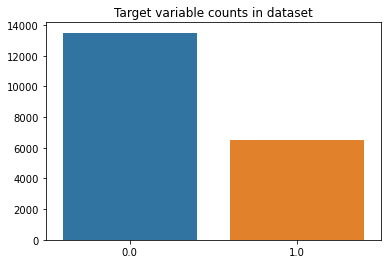

In [7]:
sns.barplot(x=unique, y=counts)
plt.title('Target variable counts in dataset')
plt.show()

## Step 1: Define explonatory variables and target variable

In [8]:
data.head()

,CUSTOMERID,COUNT,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENUREMONTHS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,7090-ZyCMx,1,Female,False,False,True,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,true,Electronic check,70.70,151.65,1.0
1,1364-wJXMS,1,Female,False,False,True,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,true,Electronic check,99.65,820.50,1.0
2,6564-sLgIC,1,Male,True,False,True,18,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,true,Electronic check,95.45,1752.55,1.0
3,7722-5mJV8,1,Female,False,True,False,28,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check,20.50,563.05,0.0
4,6694-1u7A4,1,Female,False,True,False,22,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,Month-to-month,true,Electronic check,79.20,1742.75,1.0


In [9]:
# let's identify the categorical variables
# we will capture those of type *object* and boolean
cat_vars = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype=="bool"))]

# Remove misinterpreted objects like "CustomerID"
cat_vars.pop(0)

print(cat_vars)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']


In [10]:
# now let's identify the numerical variables
num_vars = [var for var in data.columns if var not in cat_vars and var != 'CHURNVALUE' and 'CUSTOMERID' not in var]

# number of numerical variables
print(num_vars)

['COUNT', 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


   COUNT  TENUREMONTHS  MONTHLYCHARGES  TOTALCHARGES
0      1             2           70.70        151.65
1      1             8           99.65        820.50
2      1            18           95.45       1752.55
3      1            28           20.50        563.05
4      1            22           79.20       1742.75


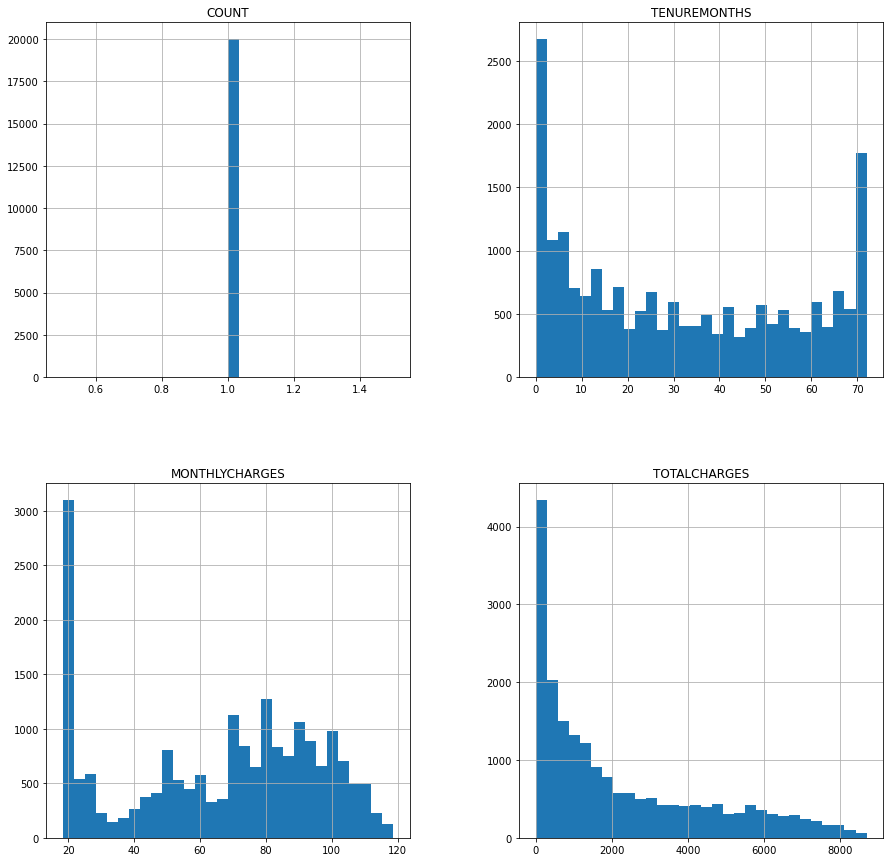

In [11]:
# lets plot histograms for all continuous variables
print(data[num_vars].head())
data[num_vars].hist(bins=30, figsize=(15,15))
plt.show()

# Missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [13]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

print(vars_with_na)

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

[]


Series([], dtype: float64)

# Numerical variables

Let's go ahead and find out what numerical variables we have in the dataset

In [14]:
print('Number of numerical variables: ', len(num_vars))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_df = data[num_vars]
scaler.fit(num_df,y=None)

# visualise the numerical variables
num_df.head()
# Before Transformation

Number of numerical variables:  4


,COUNT,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES
0,1,2,70.70,151.65
1,1,8,99.65,820.50
2,1,18,95.45,1752.55
3,1,28,20.50,563.05
4,1,22,79.20,1742.75


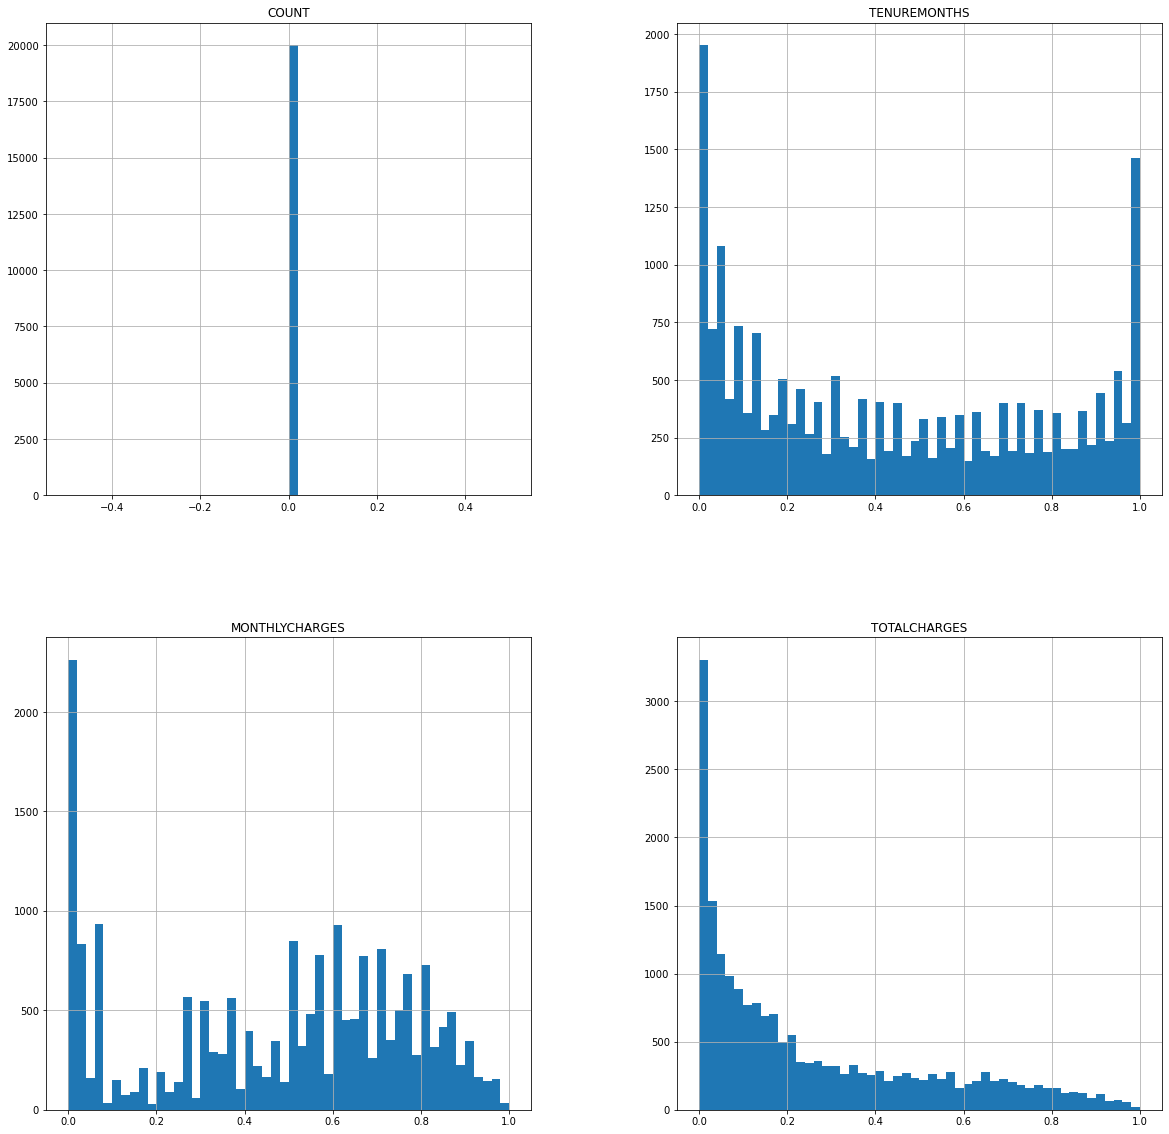

In [15]:
# lets plot histograms for all continuous variables after they are scaled
new_df = pd.DataFrame(scaler.transform(num_df),columns=data[num_vars].columns)

#new_df2 = pd.DataFrame(np.log(new_df),columns=data[num_vars].columns)
new_df.head()
new_df.hist(bins=50, figsize=(20,20))
plt.show()

## Taking care of outliers

In [16]:
def drop_outliers(df,out_name):
    iqr = 1.5 * (np.percentile(df[out_name], 75) - np.percentile(df[out_name], 25))
    df.drop(df[df[out_name] > (iqr + np.percentile(df[out_name], 75))].index, inplace=True)
    df.drop(df[df[out_name] < (np.percentile(df[out_name], 25) - iqr)].index, inplace=True)
    

drop_outliers(data,'TENUREMONTHS')
drop_outliers(data,'MONTHLYCHARGES')
drop_outliers(data,'TOTALCHARGES')


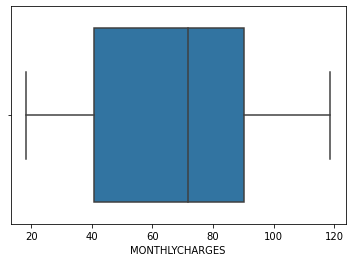

In [17]:
sns.boxplot(x=data['MONTHLYCHARGES'])
plt.show()

# Categorical variables

Let's go ahead and analyse the categorical variables present in the dataset.

In [20]:
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  16


In [21]:
# let's preview the categorical variables
data[cat_vars].head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD
0,Female,False,False,True,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,true,Electronic check
1,Female,False,False,True,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,true,Electronic check
2,Male,True,False,True,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,true,Electronic check
3,Female,False,True,False,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check
4,Female,False,True,False,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,Month-to-month,true,Electronic check


## Number of labels: cardinality

Let's evaluate how many different categories are present in each of the variables.

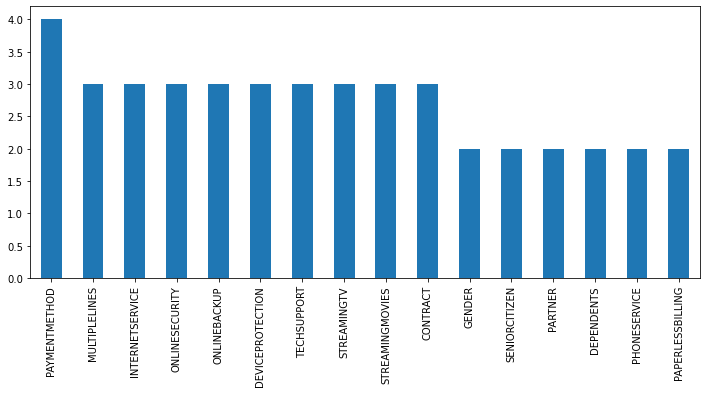

In [22]:
# get the number of unique values (cardinality) for each categorical variable

data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5));

## Rare labels:

Let's go ahead and investigate now if there are labels that are present only in a small number of customers:

In [23]:
print(cat_vars)
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['CHURNVALUE'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.01))
    print()

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']
Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)



### So all the cat variables are distributed well

In [24]:
data[cat_vars].shape, data[num_vars].shape, data['CHURNVALUE'].shape

((19995, 16), (19995, 4), (19995,))

In [25]:
# final columns that we want in our training data set are cat, num and target variables
final_cols = cat_vars + num_vars + ['CHURNVALUE']
final_cols

['GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'COUNT',
 'TENUREMONTHS',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'CHURNVALUE']

In [26]:
%%time
snowpark_train_df = session.write_pandas(data[final_cols], 'TELCO_TRAIN_SET', auto_create_table=True)

CPU times: user 559 ms, sys: 28.4 ms, total: 588 ms
Wall time: 8.53 s


In [27]:
snowpark_train_df.toPandas()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,COUNT,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,Female,False,False,True,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,true,Electronic check,1,2,70.70,151.65,1.0
1,Female,False,False,True,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,true,Electronic check,1,8,99.65,820.50,1.0
2,Male,True,False,True,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,true,Electronic check,1,18,95.45,1752.55,1.0
3,Female,False,True,False,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check,1,28,20.50,563.05,0.0
4,Female,False,True,False,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,Month-to-month,true,Electronic check,1,22,79.20,1742.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19990,Female,False,False,False,Yes,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,true,Electronic check,1,58,106.45,6145.85,1.0
19991,Female,False,False,False,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,true,Electronic check,1,25,100.25,2387.75,1.0
19992,Female,False,True,False,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,true,Credit card (automatic),1,56,99.80,5515.45,0.0
19993,Female,False,True,True,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,false,Mailed check,1,72,74.55,5430.65,0.0


# Off to training a model and deplyment


In [28]:
session.close()